# Part 3: An example workflow for designing antivirals for Zika

For this notebook we'll walk you through an example workflow of designing a new small molecule antiviral for Zika using RDKit and the LIBINVENT skills you learned earlier.

We will go through the following design steps:

1. **Understanding the target**: Zika virus NS2B-NS3 protease
2. **Designing new molecules**: Using LIBINVENT to elaborate on a portion of an existing inhibitor
3. **Evaluating candidates**: Docking, scoring, and analyzing molecular interactions using ProLIF
4. **Comparing results**: Determining which designed molecules have better properties and predicted interactions compared to the original

## Learning Objectives
By the end of this notebook, you will be able to:
- Use py3Dmol to visualize protein structures and drug-target interactions
- Design new drug molecules using LIBINVENT
- Filter molecules 
- Perform molecular docking with SMINA
- Analyze docking results and molecular interactions
- Pick your most promising design

## Introduction to Zika Virus and Our Target

### Zika Virus Background
Zika virus is a mosquito-borne flavivirus that can cause severe birth defects and neurological complications and there are no vaccine or antiviral therapeutics for the prevention or treatment. A brief intro on viral biology, once inside a host cell, its positive-sense RNA is translated into a single polyprotein that is then cut by host proteases. The NS2B–NS3 protease is produced by this cutting process and helps perform subsequent cleavages of the same polyprotein to produce the proteins the virus needs. Therefore, it's thought disrupting cutting process of NS2B-NS3 prevents viral replication. 

### Our Target: NS2B-NS3 Protease
The NS2B-NS3 protease complex made up of NS3 and NS2B. NS3 harbors a serine–histidine–aspartate catalytic triad; ~40 residues of NS2B wrap around NS3 to help form the active site and aid substrate recognition. The active site comprises subsites S1, S1′, S2 and S3 that can accommodate small-molecule binders.

### Exisiting inhibitor
A paper published in Nature Communications in early October 2025 (https://doi.org/10.1038/s41467-025-63602-z) reported a fragment screen and structure based design of a new inhibitor (PDB: 7I9O) showing micromolar IC50 that recapitulates key fragment interactions. This inhibitor will serve as our starting point for designing new molecules.

### **Let's load and visualize this structure:**

‼️ You can also do all viewing with pymol instead of inside this jupyter notebook if you prefer.

### Important files in `data`:

- `7I9O.cif`: Original download from the PDB. Holo structure of NS2B-NS3 protease (receptor and ligand bound and waters).
- `7I9O-receptor.pdb`: Apo structure (only the receptor and no waters).
- `7I9O-ligand.sdf`: Structured data file (SDF) of the 3D conformation of the bound ligand with explicit hydrogens.

In [ ]:
# --- Imports (yours) ---
import py3Dmol
import os
import subprocess
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
import yaml
from pathlib import Path
from rdkit import Chem, RDLogger

# disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

# --- Load CIF ---
cif_file = "data/7I9O.cif"
print(f"Loading structure from {cif_file}...")
with open(cif_file, "r") as f:
    cif_data = f.read()

# --- Viewer ---
view = py3Dmol.view(width=800, height=600)
view.addModel(cif_data, "cif")

# Protein as cartoon (exclude hetero atoms)
view.setStyle({'hetflag': False}, {'cartoon': {'arrows': True, 'tubes': True}})
view.addSurface(py3Dmol.MS, {'opacity': 1}, {'hetflag': False})

# Ligand(s) as sticks (hetero atoms = True)
view.setStyle({'hetflag': True}, {'stick': {'radius': 0.2, 'colorscheme': 'element'}})

# Nice defaults
view.setBackgroundColor('0xeeeeee')
view.zoomTo({'hetflag': True})   # zoom to ligand if present; else use view.zoomTo()
view.show()


Loading structure from 7I9O.cif...


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Analyzing the Original Inhibitor

Let's examine the original inhibitor more closely and understand the different binding regions and catalytic triad.


In [ ]:
import py3Dmol

cif_file = "data/7I9O.cif"
with open(cif_file, "r") as f:
    cif_data = f.read()

# ---- Viewer ----
view = py3Dmol.view(width=900, height=650)
view.addModel(cif_data, "cif")

# 1) Clear any prior styling and set safe baselines
view.setStyle({}, {})  # reset everything

# Protein as cartoon (polymer only)
view.setStyle({'hetflag': False}, {'cartoon': {'arrows': True, 'tubes': True}})

# Ligand(s) as sticks (non-polymer; exclude waters)
view.setStyle({'hetflag': True, 'not': {'resn': ['HOH','WAT']}},
              {'stick': {'radius': 0.25, 'colorscheme': 'element'}})

# S1 pocket
view.addStyle({'hetflag': False,
               'resi': [129, 130, 131, 135, 150, 151, 152, 161],} ,
              {'stick': {'radius': 0.25, 'color': '0x1f77b4'}})

# S2 pocket: target His51 and Asp83 without specifying chains
view.addStyle({'hetflag': False, 'resi': 81, 'chain': 'A'},
              {'stick': {'radius': 0.25, 'color': '0xd62728'}})  # His51
view.addStyle({'hetflag': False, 'resi': 83, 'chain': 'A'},
              {'stick': {'radius': 0.25, 'color': '0xd62728'}})  # Asp83

# S1' pocket
view.addStyle({'hetflag': False, 'chain': 'B',
               'resi': [51, 52, 132, 133],} ,
              {'stick': {'radius': 0.25, 'color': '0x2ca02c'}})

# Catalytic triad
view.addStyle({'hetflag': False, 'chain': 'B',
               'resi': [51, 75, 135],} ,
              {'stick': {'radius': 0.25, 'color': '0xFFEB3B'}})

# 3) Final touch
view.setBackgroundColor('0xeeeeee')
view.zoomTo({'hetflag': True})  # zoom to ligand(s)
view.update()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Great we can see the different regions of the binding site seperated by color. 

Each region can be briefly described: 

- Yellow (catalytic triad): His51, Asp75, and Ser135 form the catalytic triad that performs peptide-bond hydrolysis, enabling NS2B–NS3 to cleave the viral polyprotein into mature proteins. 

- Blue (S1): Deep orthosteric pocket and main fragment hotspot; ligands commonly π-stack with Tyr161 and H-bond to Asp129/Tyr130. 

- Red (S2): Subsite contacting NS2B Asp83 and NS3 His51; ligands often make an electrostatic contact to Asp83 and π-stack with His51, and this region is relatively mutation-intolerant. 

- Green (S1′): Adjacent pocket near the catalytic histidine where ligands can H-bond to the backbones of Val36 and Val52; despite fewer hits, it is also mutation-intolerant.

But what we really need is quantitative interaction data for this inhibitor so we can use it to guide our design and compare our designs to. Let's run a protein-ligand interaction tool ProLif to calculate this for us.

## Analyzing Molecular Interactions with ProLIF

### Protein-Ligand Interaction Fingerprints (ProLIF)
ProLIF analyzes protein-ligand interactions and identifies:
- Hydrogen bonds
- Hydrophobic interactions
- π-π stacking
- Salt bridges
- Water bridges
- Metal interactions

Let's analyze the interactions for the best pose of each molecule:

In [ ]:
import subprocess, MDAnalysis as mda, prolif
import gc

u = mda.Universe("data/7I9O-receptor.pdb")
protein = prolif.Molecule.from_mda(u)
# Clear MDAnalysis universe from memory
del u
gc.collect()  # Force garbage collection

lig = prolif.sdf_supplier("data/7I9O-ligand.sdf")[0]

# Run PROLIF analysis
fp = prolif.Fingerprint()
fp.run_from_iterable([lig], protein)

df = fp.to_dataframe()
# Clear intermediate objects
del fp
gc.collect()

df.T

/Users/kate_fieseler/miniconda3/envs/SMDD_env/lib/python3.9/site-packages/prolif/datafiles.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


: 

This gives us a dataframe showing what interactions are present and with what residues.

In [1]:
fp = prolif.Fingerprint()
fp.run_from_iterable([lig], protein)
# view = fp.plot_lignetwork(lig, kind="frame", frame=0)
view = fp.plot_3d(lig, protein, frame=0, display_all=False)
view

NameError: name 'prolif' is not defined

In [6]:
view = fp.plot_lignetwork(lig, kind="frame", frame=0)
view

Hopefully from both those visualizations (3D and 2D interaction plot) you can tell that this original inhibitor has interactions with residues in the S1 and S1' regions.

Important interactions:
- S1: H-bond with GLY151 and pi-stacking with TYR150, TYR130, and TYR161.
- Catalytic triad + S1': pi-stacking with HIS51. 

## Takeaways:

- The binding site is split into the catalytic triad (yellow), S1 (blue), S2 (red), and S1' (green)
- The original inhibitor is split between the S1 (blue) and S2 (red) regions of the binding site with one of the important interactions being with the catalytic HIS51. 
- The authors mention the residues in S1 and S2 are vital for exploiting in inhibitor development. 
- The S1' region is not being exploited at all and the authors mention it is an attractive area to develop into to. 

## Can you design a better inhibitor?

We will now use LIBINVENT to generate new designs starting from the portion of the original inhibitor to see if we can propose a better one. 

### Our Task
Given a portion of the original inhibitor as our scaffold, we want LIBINVENT to design new elaborations that:
- **Improve binding affinity** (better docking scores)
- **Maintain drug-like properties** (Lipinski's Rule of Five)
- **Increase interactions** with key binding site residues

### Questions to think about

- What new resiudes do we want to exploit interactions with?

### Preparing the Scaffold
We'll extract a specific portion of the original inhibitor to use as our scaffold. This scaffold will contain the core binding elements, and LIBINVENT will suggest new R-groups to attach at a specific position.

Original inhibitor
Inhibitor SMILES:  CC(C)c1nc2c(C(=O)Nc3cccc(CN)c3)cccc2[nH]1


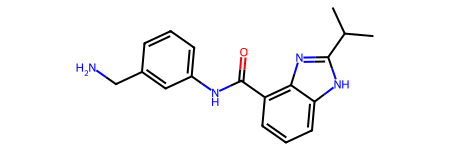

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.SDMolSupplier("data/7I9O-ligand.sdf", removeHs=False)[0]
# remove hydrogens
mol = Chem.RemoveHs(mol)
inhibitor_smiles = Chem.MolToSmiles(mol)
print("Original inhibitor")
print("Inhibitor SMILES: ", inhibitor_smiles)
Chem.MolFromSmiles(inhibitor_smiles)

Extracted scaffold


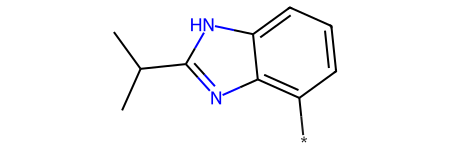

In [3]:
# Portion of the inhibitor to use as a scaffold
print("Extracted scaffold")
substructure_smiles = 'CC(C)c1nc2c([*])cccc2[nH]1'
substructure_mol = Chem.MolFromSmiles(substructure_smiles)
substructure_mol

## LIBINVENT Configuration

You were introduced to REINVENT earlier so now we'd like to use LibINVENT to propose designs from this scaffold enumerating changes at the wildcard site. Since this is an example workflow I'll provide an example block but we will use premade compounds to walk through the analysis.

We will run the `config/zika_complete.toml` to decorate the scaffold and optimizes molecules toward drug-like properties using a scoring function with four components:

- **QED** (Quantitative Estimate of Drug-likeness): Rewards molecules with QED > 0.5
- **SlogP**: Favors logP in the range 1.0-3.5
- **Molecular Weight**: Targets 250-500 Da range
- **TPSA** (Topological Polar Surface Area): Prefers 20-120 Å² for permeability

All components are combined using geometric mean, ensuring balanced drug-like profiles.

In [ ]:
from pathlib import Path
import subprocess
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Use scaffold from substructure_mol
scaffold_smiles = 'CC(C)c1nc2c([*])cccc2[nH]1'

# Write scaffold for LibINVENT
scaffold_file = Path("data/scaffold.smi")
scaffold_file.write_text(scaffold_smiles + "\n")

# Run LibINVENT
Path("output").mkdir(exist_ok=True)
config_path = Path("config/zika_complete.toml")

subprocess.run([
    "reinvent",
    "-l",
    "output/zika_druglike.log",
    config_path.as_posix()
], check=True)

CompletedProcess(args=['reinvent', '-l', 'output/zika_druglike.log', 'zika_complete.toml'], returncode=0)

LibINVENT (druglike scoring) mean Score: step 1 = 0.163 -> step 100 = 0.905 (delta +0.742)


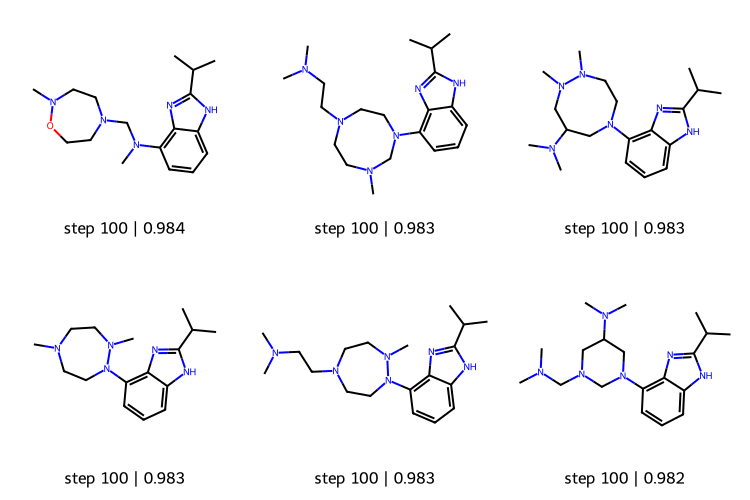

In [2]:
# Load and analyze results
report_path = Path("output/zika_1.csv").resolve()
if not report_path.exists():
    raise FileNotFoundError(f"Run LibINVENT with {config_path} to create output/zika_1.csv")

df = pd.read_csv(report_path)
df = df[df["SMILES_state"] == 1].copy()

grouped = df.groupby("step", sort=True)["Score"].mean()
start_step, end_step = grouped.index[[0, -1]]
start_score, end_score = grouped.iloc[[0, -1]]
print(
    f"LibINVENT (druglike scoring) mean Score: step {start_step} = {start_score:.3f} -> step {end_step} = {end_score:.3f} (delta {end_score - start_score:+.3f})"
)

latest = (
    df[df["step"] == end_step]
    .sort_values("Score", ascending=False)
    .head(6)
)

mols = [Chem.MolFromSmiles(s) for s in latest["SMILES"]]
legends = [f"step {end_step} | {score:.3f}" for score in latest["Score"]]

display(
    Draw.MolsToGridImage(
        mols,
        molsPerRow=3,
        subImgSize=(250, 250),
        legends=legends,
    )
)

## Filtering + Prioritizing Molecules

We can't possibly dock all the compounds we've generated, so we need to filter and prioritize. 

### Filtering
Before docking, we need to filter our generated molecules based on PAINS and BRENK filters (introduced in the first practical).

In [3]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog
import pandas as pd

# Load data
df = pd.read_csv("output/zika_1.csv")
df = df[df["SMILES_state"] == 1].copy()

# Convert SMILES to molecules
df["mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Create filter catalogs
params_pains = FilterCatalog.FilterCatalogParams()
params_pains.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
pains_catalog = FilterCatalog.FilterCatalog(params_pains)

params_brenk = FilterCatalog.FilterCatalogParams()
params_brenk.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
brenk_catalog = FilterCatalog.FilterCatalog(params_brenk)

# Check alerts
df["PAINS_hit"] = df["mol"].apply(lambda m: len(pains_catalog.GetMatches(m)) > 0 if m else False)
df["BRENK_hit"] = df["mol"].apply(lambda m: len(brenk_catalog.GetMatches(m)) > 0 if m else False)

# Print before filtering
print(f"Total compounds before filtering: {len(df)}")

# Filter out compounds with alerts
df_filtered = df[(~df["PAINS_hit"]) & (~df["BRENK_hit"])].copy()

# Print after filtering
print(f"Total compounds after filtering: {len(df_filtered)}")

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


Total compounds before filtering: 6049
Total compounds after filtering: 5751


### Prioritization
Then since we can't possibly dock all these compounds, lets prioritize the top 10 with the highest score. 

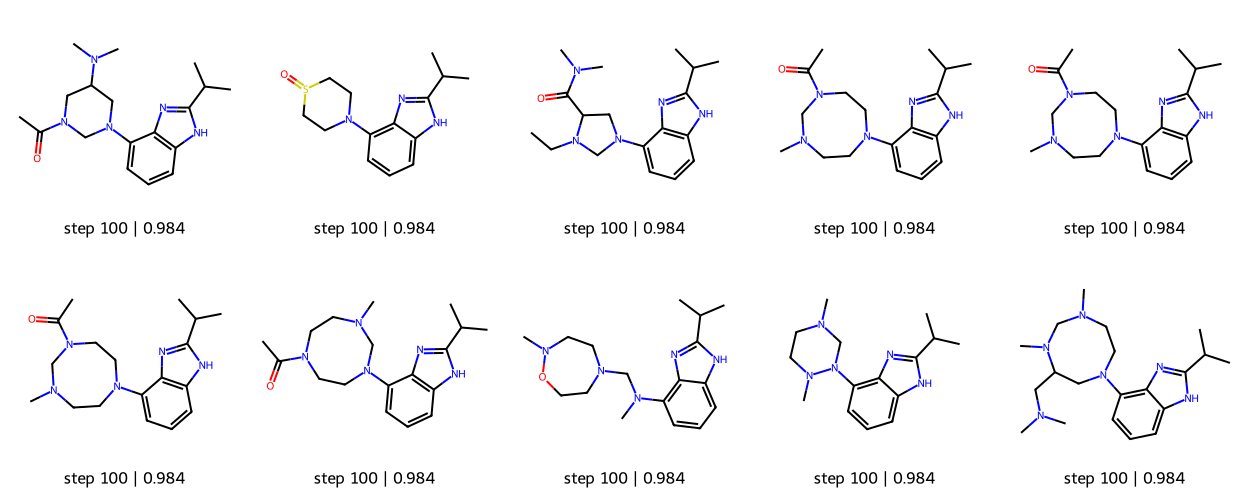

In [5]:
top_10 = df_filtered.sort_values("Score", ascending=False).head(10)
mols = top_10["mol"]
legends = [f"step {end_step} | {score:.3f}" for score in top_10["Score"]]

display(
    Draw.MolsToGridImage(
        mols,
        molsPerRow=5,
        subImgSize=(250, 250),
        legends=legends,
    )
)

Since this notebook is just an example workflow, we will work with 10 pre-generated molecules. 

**‼️ To prep these generated molecules for docking we need to save them with explicit hydrogens in the SDF to accurately represent them and measure possible hydrogen bonding interactions.** 

In [ ]:
# Save filtered molecules to SDF
filtered = ['CC(C)c1nc2c(N3CCOCC(N4CCOCC4)C3)cccc2[nH]1', 
 'CC(=O)N1CCN(c2cccc3[nH]c(C(C)C)nc23)CCN1C', 
 'CC(C)c1nc2c(N3CCN(C(=O)C4CCOC4)CC3)cccc2[nH]1', 
 'CC(=O)N1CCN(c2cccc3[nH]c(C(C)C)nc23)CC1', 
 'CC(=O)N1CCN(c2cccc3[nH]c(C(C)C)nc23)CC1', 
 'CC(=O)N1CCN(c2cccc3[nH]c(C(C)C)nc23)CC1', 
 'CC(=O)N1CCN(c2cccc3[nH]c(C(C)C)nc23)CC1', 
 'CC(=O)N1CCN(c2cccc3[nH]c(C(C)C)nc23)CC1', 
 'CC(C)c1nc2c(N3CCOC(CO)CC3)cccc2[nH]1', 
 'CC(C)c1nc2c(N3CCOCCC3CO)cccc2[nH]1'] 

filtered_mols = [Chem.MolFromSmiles(smi) for smi in filtered]

# Write molecules to SDF file
writer = Chem.SDWriter("data/filtered.sdf")
for i, mol in enumerate(filtered_mols):
    if mol is not None:  # Check if molecule is valid
        mol = Chem.AddHs(mol) # VERY IMPORTANT TO EXPLICITLY ADD HYDROGENS
        mol.SetProp("_Name", f"mol_{i}")
        writer.write(mol)
writer.close()

print(f"Saved {len([m for m in filtered_mols if m is not None])} molecules to data/filtered.sdf")

Saved 10 molecules to filtered.sdf


## Molecular Docking with SMINA

Now we'll dock our filtered molecules against the receptor using SMINA. We will have to prep the receptor using openbabel.

First, we need to dock the resolved inhibitor to provide a relative docking score to compare our generated molecules against.

### Prepare receptor

To run SMINA the receptor must be prepared with openbabel to output a `.pdbqt` file.


In [ ]:
import subprocess
# Prepare receptor PDBQT file for SMINA
subprocess.run([
    "obabel", 
    "data/7I9O-receptor.pdb", # input filename
    "-O", 
    "data/7I9O-receptor.pdbqt", # output filename
    "-xr",  # Write as a rigid body
    "-h" # Add explicit hydrogens
], check=True)
print("Receptor prepared: data/7I9O-receptor.pdbqt")

# Prepare the ligand PDBQT file for SMINA
subprocess.run([
    "obabel", 
    "data/7I9O-ligand.sdf", 
    "-O", 
    "data/7I9O-ligand.pdbqt", # output filename
    "-h" # Add explicit hydrogens
])
print("Ligand prepared: data/7I9O-ligand.pdbqt")
# TODO: Does changing the pH affect the docking results?

Receptor prepared: 7I9O-receptor.pdbqt
Ligand prepared: 7I9O-ligand.pdbqt


1 molecule converted
1 molecule converted


Now that we've prepped the receptor and ligand using openbabel we can run SMINA using commonly used settings.

In [ ]:
print("Running SMINA docking calculation for resolved inhibitor...")
result = subprocess.run([
    "smina",
    "--receptor", "data/7I9O-receptor.pdbqt",
    "--ligand", "data/7I9O-ligand.pdbqt",
    "--autobox_ligand", "data/7I9O-ligand.pdbqt",   # define box from the crystallized ligand
    "--autobox_add", "8",                      # expand the box by 8 Å
    "--exhaustiveness", "8",                   # search thoroughness 
    "--num_modes", "10",                       # request up to 10 poses
    "--seed", "0",                             # reproducible runs
    "--out", "data/7I9O-ligand-docked.sdf",       
], check=True)

Running SMINA docking calculation for resolved inhibitor...
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| 

Before we even look at the results we should run these poses through PoseBusters to filter out the unphysical ones. This does a series of physical plausability checks which even SMINA can produce unphysical conformations. Check out the repo if you're interested: https://github.com/maabuu/posebusters?tab=readme-ov-file.

In [ ]:
# Run PoseBusters
import subprocess
subprocess.run([
    "bust",
    "data/7I9O-ligand-docked.sdf",
    "-l",
    "data/7I9O-ligand.pdb",
    "-p",
    "data/7I9O-receptor.pdb",
    "--outfmt",
    "csv",
    "--output",
    "data/7I9O-ligand-docked-busted.csv"
])

[11:35:08] WARNING: More than one matching pattern found - picking one

[11:35:08] WARNING: More than one matching pattern found - picking one

[11:35:20] WARNING: More than one matching pattern found - picking one

[11:35:20] WARNING: More than one matching pattern found - picking one

[11:35:32] WARNING: More than one matching pattern found - picking one

[11:35:32] WARNING: More than one matching pattern found - picking one

[11:35:44] WARNING: More than one matching pattern found - picking one

[11:35:44] WARNING: More than one matching pattern found - picking one

[11:35:56] WARNING: More than one matching pattern found - picking one

[11:35:56] WARNING: More than one matching pattern found - picking one

[11:36:09] WARNING: More than one matching pattern found - picking one

[11:36:09] WARNING: More than one matching pattern found - picking one

[11:36:21] WARNING: More than one matching pattern found - picking one

[11:36:21] WARNING: More than one matching pattern found - picki

CompletedProcess(args=['bust', '7I9O-ligand-docked.sdf', '-l', '7I9O-ligand.pdb', '-p', '7I9O-receptor.pdb', '--outfmt', 'csv', '--output', '7I9O-ligand-docked-busted.csv'], returncode=0)

We can load the results and any values that are `False` means that pose did not pass that check.

In [ ]:
import pandas as pd
df = pd.read_csv("data/7I9O-ligand-docked-busted.csv")
boolean_cols = [col for col in df.columns[3:] if col != 'internal_energy']
df_bool = df[boolean_cols].replace({True: 1, False: 0, 'True': 1, 'False': 0})
df['passed'] = df_bool.sum(axis=1)
df['percentage_passed'] = (df_bool.sum(axis=1) / len(boolean_cols)) * 100
# just show percentage passed
print("Pose: Percentage of filters passed")
df['percentage_passed']

Pose: Percentage of filters passed


0    88.461538
1    88.461538
2    88.461538
3    88.461538
4    88.461538
5    88.461538
6    88.461538
7    88.461538
8    88.461538
Name: percentage_passed, dtype: float64

We can see that all passed the same percentage of filters (some failed most likely due to failing to calculate, we will just ignore those). So let's look at the best scoring pose and compare it to our crystal structure to make sure it's realistic and therefore we can trust the docking score. 

In [ ]:
# Let's look at the docking results using py3Dmol
import py3Dmol
import pandas as pd
from rdkit import Chem

# Read file contents
with open("data/7I9O-ligand-docked.sdf", "r") as f:
    ligand_sdf = f.read()

with open("data/7I9O.cif", "r") as f:
    cif_data = f.read()

# Load docked molecules and find the best pose
docked_mols = Chem.SDMolSupplier("data/7I9O-ligand-docked.sdf")
best_mol = None
best_score = float('inf')

for mol in docked_mols:
    if mol is not None and mol.HasProp("minimizedAffinity"):
        score = float(mol.GetProp("minimizedAffinity"))
        if score < best_score:
            best_score = score
            best_mol = mol

# Convert best molecule to SDF string
if best_mol is not None:
    best_sdf = Chem.MolToMolBlock(best_mol)
    print(f"Best docking score: {best_score:.2f} kcal/mol (RED)")
    print('Resolved Inhibitor (YELLOW)')
else:
    print("No valid docking poses found")
    best_sdf = ""

view = py3Dmol.view(width=800, height=600)
view.addModel(cif_data, "cif")
if best_sdf:
    view.addModel(best_sdf, "sdf")

# Style protein as cartoon (gray)
view.setStyle({'hetflag': False}, {'cartoon': {'color': 'gray'}})

# Style ground truth ligand (from CIF) as yellow sticks
view.setStyle({'hetflag': True, 'model': 0}, {'stick': {'radius': 0.2, 'color': 'yellow'}})

# Style best docking pose as red sticks (if present)
if best_sdf:
    view.setStyle({'hetflag': True, 'model': 1}, {'stick': {'radius': 0.2, 'color': 'red'}})

view.setBackgroundColor('0xeeeeee')
view.zoomTo({'hetflag': True})
view.show()

Best docking score: -8.45 kcal/mol (RED)
Resolved Inhibitor (YELLOW)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Just looking by eye, the best scoring docked pose is very similar (except the flipped carbonyl in the middle) to the resolved pose so we can trust it! Nice! 

Now lets dock the 10 generated compounds using the same prepared receptor.

In [ ]:
print("Running SMINA docking calculations...")

result = subprocess.run([
    "smina",                                                
    "--receptor", "data/7I9O-receptor.pdbqt",                    # receptor in PDBQT (no ligand)
    "--ligand", "data/filtered.sdf",                             # ligand input 
    "--autobox_ligand", "data/7I9O-ligand.pdbqt",                # set search box from crystallized ligand
    "--autobox_add", "8",                                   # expand the box by 8 Å
    "--out", "data/filtered_docked.sdf",                         # output file
    "--exhaustiveness", "8",                                # search thoroughness (higher = slower)
    "--seed", "1950",                                       # RNG seed for reproducibility
    "--num_modes", "3"                                      # max number of poses to output
], check=True)  # raise CalledProcessError if SMINA exits non-zero
    

Running SMINA docking calculations...
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1950

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+---

## Filter docked poses using PoseBusters

We will run PoseBusters again.


In [ ]:
subprocess.run([
    "bust",
    "data/filtered_docked.sdf",
    "-p",
    "data/7I9O-receptor.pdb",
    "--outfmt",
    "csv",
    "--output",
    "data/filtered_docked-busted.csv"
])

[11:53:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[11:53:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

CompletedProcess(args=['bust', 'filtered_docked.sdf', '-p', '7I9O-receptor.pdb', '--outfmt', 'csv', '--output', 'filtered_docked-busted.csv'], returncode=0)

In [ ]:
import pandas as pd
df = pd.read_csv("data/filtered_docked-busted.csv")
boolean_cols = [col for col in df.columns[3:] if col != 'internal_energy']
df_bool = df[boolean_cols].replace({True: 1, False: 0, 'True': 1, 'False': 0})
df['passed'] = df_bool.sum(axis=1)
df['percentage_passed'] = (df_bool.sum(axis=1) / len(boolean_cols)) * 100
# just show percentage passed
df.columns
df[['molecule', 'position', 'percentage_passed']]

,molecule,position,percentage_passed
0,mol_0,0,95.0
1,mol_0,1,95.0
2,mol_0,2,95.0
3,mol_1,3,100.0
4,mol_1,4,100.0
5,mol_1,5,100.0
6,mol_2,6,95.0
7,mol_2,7,95.0
8,mol_2,8,95.0
9,mol_3,9,95.0


You can see that there are some molecules don't pass 100% of the checks, therefore lets only consider the ones that pass 100%. Additionally, if there are multiple poses for each molecule that passed, lets just save the best scoring ones. 

In [ ]:
# write new SDF with only the lowest scoring passed poses
from rdkit import Chem
writer = Chem.SDWriter("data/filtered_docked-busted-passed.sdf")
molecule_scores = {}

# First pass: collect lowest scores per molecule
for i, mol in enumerate(Chem.SDMolSupplier("data/filtered_docked.sdf")):
    if mol is not None and mol.HasProp("minimizedAffinity") and df.iloc[i]['percentage_passed'] == 100:
        mol_name = df.iloc[i]['molecule']
        score = float(mol.GetProp("minimizedAffinity"))
        if mol_name not in molecule_scores or score < molecule_scores[mol_name][1]:
            molecule_scores[mol_name] = (i, score)

# Second pass: write only the lowest scoring pose per molecule and add Hydrogen atoms
for i, mol in enumerate(Chem.SDMolSupplier("data/filtered_docked.sdf")):
    if mol is not None and mol.HasProp("minimizedAffinity"):
        mol_name = df.iloc[i]['molecule']
        if mol_name in molecule_scores and molecule_scores[mol_name][0] == i:
            mol.SetProp("_Name", mol_name)
            writer.write(mol)

writer.close()
print(f"Saved {len(molecule_scores)} molecules to data/filtered_docked-busted-passed.sdf")

Saved 3 molecules to filtered_docked-busted-passed.sdf


[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:05:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

In [ ]:
# Add hydrogen atoms to the 3D conformer of the ligand using openbabel
import subprocess
subprocess.run([
    "obabel", 
    "data/filtered_docked-busted-passed.sdf", # input filename
    "-O", 
    "data/filtered_docked-busted-passed-hs.sdf", # output filename
    "-xr",  # Write as a rigid body
    "-h" # Add explicit hydrogens
], check=True)
print("Receptor prepared: data/filtered_docked-busted-passed-hs.sdf")

Receptor prepared: filtered_docked-busted-passed-hs.sdf


3 molecules converted


## Analyze Docking Poses

Let's only look at the distribution of the best scores then look how similar they are in py3Dmol and ProLIF.


In [ ]:
# make dataframe of the final passing molecules
mols = Chem.SDMolSupplier("data/filtered_docked-busted-passed-hs.sdf")
df = pd.DataFrame([(mol.GetProp("_Name"), float(mol.GetProp("minimizedAffinity"))) for mol in mols])
df.columns = ['molecule', 'docking_score']
df.sort_values(by='docking_score', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
# add resolved inhibitor to the dataframe
df = pd.concat([df, pd.DataFrame([('resolved_inhibitor', best_score)], columns=['molecule', 'docking_score'])])
df

NameError: name 'Chem' is not defined

The docking score should be a similar metric to delta delta G where a lower score is better. So we can see the best docking scores are all higher than the resolved inhibitor docking score meaning according to this metric we did not design a "better" inhibitor with a better docking score. But that's just one metric.

Let's look at the predicted interactions of these best poses.

In [ ]:
import MDAnalysis as mda
import prolif
import gc
u = mda.Universe("data/7I9O-receptor.pdb")
protein = prolif.Molecule.from_mda(u)
# Clear MDAnalysis universe from memory
del u
gc.collect()  # Force garbage collection

ligs = prolif.sdf_supplier("data/filtered_docked-busted-passed-hs.sdf")

# Run PROLIF analysis only for 
fp = prolif.Fingerprint()
fp.run_from_iterable(ligs, protein)

df = fp.to_dataframe()
# Clear intermediate objects
del fp
gc.collect()

df

/Users/kate_fieseler/miniconda3/envs/prolif/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kate_fieseler/miniconda3/envs/prolif/lib/python3.14/site-packages/prolif/datafiles.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/Users/kate_fieseler/miniconda3/envs/prolif/lib/python3.14/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning

: 

From just looking at the dataframe the only molecule (identified by `Frame`) is number 1 since it is the only one with a h-bond. Let's look at that one. 

In [ ]:
fp = prolif.Fingerprint()
fp.run_from_iterable(ligs, protein)
view = fp.plot_lignetwork(ligs[1], display_all=False)
view

NameError: name 'prolif' is not defined

In [4]:
fp = prolif.Fingerprint()
fp.run_from_iterable(ligs, protein)
view = fp.plot_3d(ligs[1], protein, frame=1, display_all=False)
view

100%|██████████| 3/3 [00:00<00:00, 76.66it/s]


ModuleNotFoundError: No module named 'py3Dmol'

On further look you might notice weird very straight bonds those should've been caught by PoseBusters... Maybe thies was caught in the filters that were failing. Something to be aware of. 

## Final Analysis and Comparison

### Comparing Designed Molecules with Original Inhibitor

Let's compare our best designed molecules with the original inhibitor across multiple criteria:


Loading docked resolved inhibitor...
✓ Loaded resolved inhibitor: 
  Best docking score: -8.43 kcal/mol
  SMILES: [C][C]([C])c1nc2c(C(=O)Nc3[c][c][c]c([C]N)[c]3)[c][c][c]c2[nH]1

Loading designed molecules...
✓ Loaded design: mol_1 (score: -6.84 kcal/mol)
✓ Loaded design: mol_8 (score: -6.68 kcal/mol)
✓ Loaded design: mol_9 (score: -6.10 kcal/mol)

Total designs loaded: 3


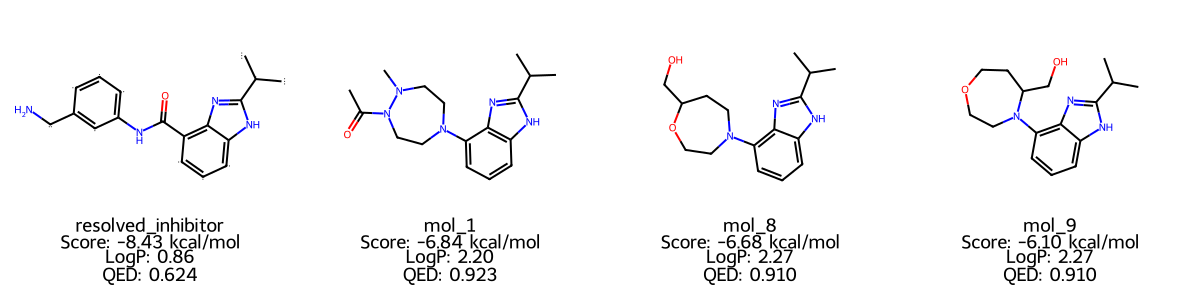


Summary of molecules:
              name  docking_score      mw    logp  hbd  hba      qed
resolved_inhibitor      -8.432957 292.257 0.86089    3    3 0.623627
             mol_1      -6.843150 315.421 2.20160    1    4 0.922939
             mol_8      -6.684440 289.379 2.27390    2    4 0.909736
             mol_9      -6.096590 289.379 2.27390    2    4 0.909736


In [ ]:
# Load the docked resolved inhibitor and designed molecules from SDF files
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Load the docked resolved inhibitor - find the best pose
print("Loading docked resolved inhibitor...")
docked_inhibitor_mols = Chem.SDMolSupplier("7I9O-ligand-docked.sdf", removeHs=False)
resolved_inhibitor = None
resolved_docking_score = None

for mol in docked_inhibitor_mols:
    if mol is not None and mol.HasProp("minimizedAffinity"):
        score = float(mol.GetProp("minimizedAffinity"))
        if resolved_docking_score is None or score < resolved_docking_score:
            resolved_docking_score = score
            resolved_inhibitor = mol

if resolved_inhibitor is not None:
    resolved_inhibitor_name = resolved_inhibitor.GetProp("_Name") if resolved_inhibitor.HasProp("_Name") else "resolved_inhibitor"
    resolved_smiles = Chem.MolToSmiles(Chem.RemoveHs(resolved_inhibitor))
    print(f"✓ Loaded resolved inhibitor: {resolved_inhibitor_name}")
    print(f"  Best docking score: {resolved_docking_score:.2f} kcal/mol")
    print(f"  SMILES: {resolved_smiles}")
else:
    print("⚠ Warning: Could not load resolved inhibitor")

# Load the designed molecules that passed all filters
print("\nLoading designed molecules...")
designed_mols = Chem.SDMolSupplier("data/filtered_docked-busted-passed-hs.sdf", removeHs=False)
designed_data = []

for mol in designed_mols:
    if mol is not None:
        mol_name = mol.GetProp("_Name") if mol.HasProp("_Name") else "unknown"
        docking_score = float(mol.GetProp("minimizedAffinity")) if mol.HasProp("minimizedAffinity") else None
        smiles = Chem.MolToSmiles(Chem.RemoveHs(mol))
        
        # Calculate molecular properties
        mol_no_h = Chem.RemoveHs(mol)
        props = {
            'name': mol_name,
            'molecule': mol_name,
            'docking_score': docking_score,
            'smiles': smiles,
            'mw': Descriptors.MolWt(mol_no_h),
            'logp': Descriptors.MolLogP(mol_no_h),
            'hbd': Descriptors.NumHDonors(mol_no_h),
            'hba': Descriptors.NumHAcceptors(mol_no_h),
            'rotbonds': Descriptors.NumRotatableBonds(mol_no_h),
            'tpsa': Descriptors.TPSA(mol_no_h),
            'qed': Chem.QED.qed(mol_no_h),
            'mol_object': mol,  # Store the molecule object for later use
            'smiles': smiles
        }
        designed_data.append(props)
        print(f"✓ Loaded design: {mol_name} (score: {docking_score:.2f} kcal/mol)")

print(f"\nTotal designs loaded: {len(designed_data)}")

# Create DataFrames for easier access
if resolved_inhibitor is not None:
    resolved_props = {
        'name': 'resolved_inhibitor',
        'molecule': 'resolved_inhibitor',
        'docking_score': resolved_docking_score,
        'smiles': resolved_smiles,
        'mw': Descriptors.MolWt(Chem.RemoveHs(resolved_inhibitor)),
        'logp': Descriptors.MolLogP(Chem.RemoveHs(resolved_inhibitor)),
        'hbd': Descriptors.NumHDonors(Chem.RemoveHs(resolved_inhibitor)),
        'hba': Descriptors.NumHAcceptors(Chem.RemoveHs(resolved_inhibitor)),
        'rotbonds': Descriptors.NumRotatableBonds(Chem.RemoveHs(resolved_inhibitor)),
        'tpsa': Descriptors.TPSA(Chem.RemoveHs(resolved_inhibitor)),
        'qed': Chem.QED.qed(Chem.RemoveHs(resolved_inhibitor)),
        'mol_object': resolved_inhibitor,
        'smiles': resolved_smiles
    }
    all_molecules_data = [resolved_props] + designed_data
else:
    all_molecules_data = designed_data

# Create DataFrame (excluding mol_object column)
molecules_df = pd.DataFrame(all_molecules_data)
molecules_df = molecules_df.sort_values('docking_score', ascending=True).reset_index(drop=True)

# Create multi-line captions with docking score, logp, and QED
from rdkit.Chem import Draw

captions = []
for idx, row in molecules_df.iterrows():
    name = row['name']
    docking_score = row['docking_score'] if pd.notna(row['docking_score']) else 'N/A'
    logp = row['logp'] if pd.notna(row['logp']) else 'N/A'
    qed = row['qed'] if pd.notna(row['qed']) else 'N/A'
    
    # Format values
    if isinstance(docking_score, (int, float)):
        docking_str = f"Score: {docking_score:.2f} kcal/mol"
    else:
        docking_str = f"Score: {docking_score}"
    
    if isinstance(logp, (int, float)):
        logp_str = f"LogP: {logp:.2f}"
    else:
        logp_str = f"LogP: {logp}"
    
    if isinstance(qed, (int, float)):
        qed_str = f"QED: {qed:.3f}"
    else:
        qed_str = f"QED: {qed}"
    
    caption = f"{name}\n{docking_str}\n{logp_str}\n{qed_str}"
    captions.append(caption)

opts = Draw.MolDrawOptions()
opts.legendFontSize = 20
opts.legendFraction = 0.25
# Display molecules in grid with multi-line captions (increased size for better readability)
display(Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in molecules_df['smiles'].tolist()], 
    molsPerRow=4, 
    subImgSize=(300, 300),  # Increased from 200x200 to 300x300 for larger text and molecules
    legends=captions,
    drawOptions=opts
))

print("\n" + "="*60)
print("Summary of molecules:")
print("="*60)
print(molecules_df[['name', 'docking_score', 'mw', 'logp', 'hbd', 'hba', 'qed']].to_string(index=False))

## Conclusions

**Positives:**
- The logP has increased for all compounds relative to the original.
- The QED increased for all of them as well. 

**Negatives:**
- There are no designs with better docking scores than the original.
- There were no designs which introduced more hydrogen bonding interactions and therefore no new h-bond interactions with new residues compared to the original.

While I don't think we've designed a better inhibitor than the original from a structure based context (no new interactions and worse docking scores), we've improved the 2D metrics such as QED and logP! This should come as no suprise since we ran LibINVENT which used a RL framework to design molecules optimizing these 2D properties. Maybe using an actual structure based generative model could result in improvements for the docking score and interactions... 🤔


### What to think about

Now that you've completed the structure-based drug discovery workflow, you'll perform your own workflow to see if you can design better inhibitors than here. Overall some questions to consider for any workflow:

1. **Which molecule performed best overall?** Consider docking score, drug-like properties, and number of interactions.

2. **How do your designed molecules compare to the original inhibitor?** 
   - Did any achieve better docking score?
   - Are the drug-like properties maintained or improved?
   - Do they form more or different types of interactions?
   - Are there more interactions with less mutable residues or more mutable residues from the deep mutational scanning experiments?
   - How did the docking performance of the original resolved inhibitor perform? Were the true interactions found?

3. **What patterns do you notice?**
   - Is there a correlation between molecular weight and docking score (or any other metrics)?
   - Do more interactions always lead to better binding?
   - How does LogP affect the results?

4. **What would you do next?**
   - Which molecules would you select for further testing?
   - What modifications might you try next?

This represents a complete computational drug discovery pipeline that can be applied to any protein target!


## Appendix: Useful Commands for This Workflow

### Command Line Tools

```bash
# OpenBabel - Prepare receptor for docking (PDB to PDBQT)
obabel data/receptor.pdb -O data/receptor.pdbqt -xr -h

# OpenBabel - Prepare ligand for docking (SDF to PDBQT)
obabel data/ligand.sdf -O data/ligand.pdbqt -h

# OpenBabel - Add hydrogens to SDF file
obabel data/input.sdf -O data/output.sdf -h

# SMINA docking
smina --receptor data/receptor.pdbqt --ligand data/ligand.pdbqt --out data/docked.sdf \
      --autobox_ligand data/ligand.pdbqt --autobox_add 8 \
      --exhaustiveness 8 --num_modes 10 --seed 0

# PoseBusters - Filter docked poses for physical plausibility
bust data/docked.sdf -p data/receptor.pdb -l data/reference_ligand.pdb \
     --outfmt csv --output data/results.csv
```
